### In vivo tissue images
The images from the new experiments show cells from the fatbody of a fly that was exposed to different treatment (starvation, Chloroquine) and then killed and dissected at different timepoints, typically 4 hrs of starvation or 1 hr after refeed. The tissues were imaged using flucorescence microscopy. The images are not yet sorted into a data set, so we will need to evaluate what to include and how to sort the data. 

Each image has either three or four channels. Channels 1 and 2 show fluorescent probes expressed by the cells themselves while channel 0 shows the blue stained nuclei and channel 3 shows specific proteins that have been stained with the A467 conjugate. Channel 3 is not always present.

0. Dapi blue (nuclei)
1. GFP green (mutants)
2. mCherry red (atg8a spots)
3. A467 far-red (other proteins)

- The bio group is unhappy with the Cellpose segmentation method because it is time consuming and they don't catch all the red spots. They also cannot use the same set-up on all images because the red dots differ a lot in size since the method they use in Cellpose requires a size constrain.

-  They have some images with atg8a spot segmentation performed using cellpose (these are shown in the separate notebook "cellpose_masks"). Can we use them as GT even if all dots are not found? Maybe we can disregard areas of the images where no dots have been found using a masked loss function?
- There is sometimes a high signal-to-noise ratio in red channel (specially in fed cells where there are very few dots). Do we need to do some processing to be sure GT makes sense? Like disregarding points that are lower than a certain threshold?
- Even though they perform spot segmentation on the full image, eventually they want to perform some statistical analysis on cell level. So far they use a polygon segmentation tool that works ok, but they usually end up manually segmenting the mutated cells since it is easier to see that the overlap is not great when the cells are contrasted against the background.
- Can we improve the cell segmentation with a machine learning tool, since there is a lot of information in the low pixel value range? And since the green cells are easy to spot, it could perhaps be quite fast to generate a GT using these cells?
-  Sometimes the cell limits are colored red. Can this be a sign of exocytosis: "Lipidation of the late autophagosome marker LC3 is required for the secretion of lysomal contents into the extracellular space, as this direct the lysosomes to fuse with the plasma membrane" (lysosome signalling article). Anyway, these can become tricky since they are also bright and may be merging into real spots.
-  Can green/blue/far-re channels be used to say something about what part that could be defined as the cytosol background in the cell? Since there are some areas that are dark (fat) in all channels, this can maybe be used to find which areas to include in background measurements.
 

In [44]:
# Functions used in this notebook. I left them here so that you can see how the image are processed before plotting

%matplotlib inline
import numpy as np
from IPython import embed
import matplotlib.colors as colors
from PIL import Image
import tifffile
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import os

def tiff_to_array(tiff_path):
    with tifffile.TiffFile(tiff_path) as tiff:
        image = tiff.asarray() 
    return image


def plot_cropped(name, image, vmax_factor, start_x, start_y, dim):
     # Get separate channels
    blue_image = image[0,:,:]
    green_image = image[1,:,:]
    red_image = image[2,:,:]
    if image.shape[0] == 4:
        far_red_image = image[3,:,:]
    else: 
        far_red_image = np.zeros_like(blue_image) # make zero array if no 4th channel
        
    # crop
    blue_image_cropped = crop(blue_image, start_x, start_y, dim)
    green_image_cropped = crop(green_image, start_x, start_y, dim)
    red_image_cropped = crop(red_image, start_x, start_y, dim)
    far_red_image_cropped = crop(far_red_image, start_x, start_y, dim)
    
    # Create the colormaps
    blue_cmap = LinearSegmentedColormap.from_list("", ["black","blue"])
    green_cmap = LinearSegmentedColormap.from_list("", ["black","green"])
    red_cmap = LinearSegmentedColormap.from_list("", ["black","red"]) 
    grey_cmap = LinearSegmentedColormap.from_list("", ["black","white"])
    
    # find max to scale both images by the highest value
    max_blue = np.max(blue_image_cropped)
    max_green = np.max(green_image_cropped)
    max_red = np.max(red_image_cropped)
    max_far_red = np.max(far_red_image_cropped)
    
    # PLot figures 
    plt.rcParams['figure.figsize'] = [10, 10] 
    fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout=True)
    im1 = axes[0][0].imshow(blue_image_cropped, cmap = blue_cmap, vmin= 0, vmax = vmax_factor*max_blue)
    im2 = axes[0][1].imshow(green_image_cropped, cmap = green_cmap, vmin= 0, vmax = vmax_factor*max_green)
    im3 = axes[1][0].imshow(red_image_cropped, cmap = red_cmap,vmin= 0, vmax = vmax_factor*max_red)
    im4 = axes[1][1].imshow(far_red_image_cropped, cmap = grey_cmap, vmin= 0, vmax = vmax_factor*max_far_red)

    axes[0][0].set_title('Dapi blue (nuclei)')
    axes[0][1].set_title('GFP green (mutants)')
    axes[1][0].set_title('mCherry red (atg8a puncta)')
    if image.shape[0] == 4:
        axes[1][1].set_title('A467 far-red (pAMPK, atp5 or p4E-BP)')
    else:
        axes[1][1].set_title('No A467 far-red')
    
    # Add colorbar 
    cbar1 = fig.colorbar(im1, ax=axes[0][0], shrink = 0.8)
    cbar2 = fig.colorbar(im2, ax=axes[0][1], shrink = 0.8)
    cbar2 = fig.colorbar(im3, ax=axes[1][0], shrink = 0.8)
    cbar2 = fig.colorbar(im4, ax=axes[1][1], shrink = 0.8)

    fig.suptitle(name)


def crop(image, start_x, start_y, crop_size):
    crop_start_x = start_x
    crop_start_y = start_y
    image_cropped = image[crop_start_x:crop_start_x+crop_size,crop_start_y:crop_start_y+crop_size]
    return image_cropped
    
def plot_intensities(image_name, channel, image, int1, int2, int3, int4, start_x, start_y, dim):
    image = image[channel,:,:]
    image_cropped = crop(image, start_x, start_y, dim)

    # find max and make cmap
    max_value = np.max(image_cropped)

    if channel == 0:
        cmap = LinearSegmentedColormap.from_list("", ["black","blue"])
    if channel == 1:
        cmap = LinearSegmentedColormap.from_list("", ["black","green"])
    if channel == 2:    
        cmap = LinearSegmentedColormap.from_list("", ["black","red"])
    if channel ==3:
        cmap = LinearSegmentedColormap.from_list("", ["black","white"])

    plt.rcParams['figure.figsize'] = [20, 5] 
    fig, axes = plt.subplots(nrows=1, ncols=4, constrained_layout=True)
    im1 = axes[0].imshow(image_cropped, cmap = cmap, vmin= 0, vmax = 1/int1*max_value)
    im2 = axes[1].imshow(image_cropped, cmap = cmap, vmin= 0, vmax = 1/int2*max_value)
    im3 = axes[2].imshow(image_cropped, cmap = cmap, vmin= 0, vmax = 1/int3*max_value)
    im4 = axes[3].imshow(image_cropped, cmap = cmap, vmin= 0, vmax = 1/int4*max_value)

    # Add colorbar 
    cbar1 = fig.colorbar(im1, ax=axes[0], shrink = 0.8)
    cbar2 = fig.colorbar(im2, ax=axes[1], shrink = 0.8)
    cbar2 = fig.colorbar(im3, ax=axes[2], shrink = 0.8)
    cbar2 = fig.colorbar(im4, ax=axes[3], shrink = 0.8)

    axes[0].set_title(f'max / {int1}')
    axes[1].set_title(f'max / {int2}')
    axes[2].set_title(f'max / {int3}')
    axes[3].set_title(f'max / {int4}')

    fig.suptitle(image_name)

def plot_new_merged_cell(image, bright_factor,start_x, start_y, dim):
    blue_image = image[0,:,:]
    green_image = image[1,:,:]
    red_image = image[2,:,:]

    if image.shape[0] == 4:
        far_red_image = image[3,:,:]
    else: 
        far_red_image = np.zeros_like(blue_image) # make zero array if no 4th channel
    
    # crop
    blue_image_cropped = crop(blue_image, start_x, start_y, dim)
    green_image_cropped = crop(green_image, start_x, start_y, dim)
    red_image_cropped = crop(red_image, start_x, start_y, dim)
    far_red_image_cropped = crop(far_red_image, start_x, start_y, dim)

    #  scale between 0 and 1, using the max of green/red
    max_value = np.max([np.max(blue_image),np.max(green_image),np.max(red_image), np.max(far_red_image)])
    ## FIXME: just manually reducing green to see better, how to do this so that we can see overlaps?
    green_image_normalized = 0.5*green_image_cropped/max_value
    red_image_normalized = red_image_cropped/max_value

    # add empty blue channel
    blue_channel = np.zeros_like(red_image_normalized)
    
    red_cmap = LinearSegmentedColormap.from_list("", ["black","red"])
    green_cmap = LinearSegmentedColormap.from_list("", ["black","green"])

    # Merge the three channels into a single array
    merged_image = ( np.dstack((red_image_normalized, green_image_normalized, blue_channel)))
    merged_image = brighten_image(merged_image, bright_factor)
    
    # plot
    plt.rcParams['figure.figsize'] = [9, 4.5] 
    fig, axes = plt.subplots(nrows=1, ncols=3, constrained_layout=True)
    im1 = axes[0].imshow(merged_image[:,:,0], cmap = red_cmap)
    im2 = axes[1].imshow(merged_image[:,:,1], cmap = green_cmap)
    im3 = axes[2].imshow(merged_image)
    
    # titles
    axes[0].set_title('red channel')
    axes[1].set_title('green channel')
    axes[2].set_title('merged')

def brighten_image(img, factor):
    brightened_image = img*factor
    brightened_image = np.clip(brightened_image, 0, 1)
    return brightened_image

def nonzero_elements(image):
    nonzero_indices = np.nonzero(image)
    nonzero_elements = image[nonzero_indices]
    return nonzero_elements

def make_histograms(image):
    blue_image = image[0,:,:]
    green_image = image[1,:,:]
    red_image = image[2,:,:]

    if image.shape[0] == 4:
        far_red_image = image[3,:,:]
    else: 
        far_red_image = np.zeros_like(blue_image) # make zero array if no 4th channel

    red_image_flat = nonzero_elements(red_image)
    green_image_flat = nonzero_elements(green_image)
    blue_image_flat = nonzero_elements(blue_image)
    far_red_image_flat = nonzero_elements(far_red_image)

    plt.rcParams['figure.figsize'] = [9, 18] 
    fig, axes = plt.subplots(nrows=4, ncols=1)
    im1 = axes[0].hist(blue_image_flat,  bins = 2000, range= (1,2000),alpha=0.7, color='blue')
    im2 = axes[1].hist(green_image_flat,  bins = 2000, range= (1,2000),alpha=0.7, color='green')
    im3 = axes[2].hist(red_image_flat,bins = 2000, range= (1,2000), alpha=0.7, color='red')
    im4 = axes[3].hist(far_red_image_flat,  bins = 2000, range= (1,2000),alpha=0.7, color='black')
    
    axes[0].set_xlabel('Pixel value')
    axes[1].set_xlabel('Pixel value')
    axes[2].set_xlabel('Pixel value')
    axes[3].set_xlabel('Pixel value')
    
    axes[0].set_ylabel('Frequencey')
    axes[1].set_ylabel('Frequency')
    axes[2].set_ylabel('Frequency')
    axes[3].set_ylabel('Frequency')

    ymax_blue=im1[0].max().astype(np.uint16)
    ymax_green=im2[0].max().astype(np.uint16)
    ymax_red=im3[0].max().astype(np.uint16)
    ymax_far_red=im4[0].max().astype(np.uint16)

    axes[0].set_ylim([0,ymax_blue/3])
    axes[1].set_ylim([0,ymax_green/3])
    axes[2].set_ylim([0,ymax_red/3])
    axes[3].set_ylim([0,ymax_far_red/3])
    
    axes[0].set_title('Dapi blue (nuclei)', y=1.0, pad=-18)
    axes[1].set_title('GFP (mutations)', y=1.0, pad=-18)
    axes[2].set_title('mCherry (atg8a)', y=1.0, pad=-18)
    axes[3].set_title('A467 far-red (pAMPK, atp5 or p4E-BP)', y=1.0, pad=-18)


## Some cells from a starvation experiment
The following images are from cells that have been starved (S4h) or fed (F). In the green cells the Sun gene has been mutated. Siri was not sure if it was the ATP5 or pAMPK that was stained with far-red in channel 3, both are mentioned in the folder name but only atp5 in the image name. 

- There is a lot of pixel information at lower range that could be used for cell segmentation
- The cell background looks quite similar except of in mutated cells where it can differ from the rest depending on the mutations
- One of the green cells is probably chopped off without a nucleous, we should be careful with those cells if we make a GT

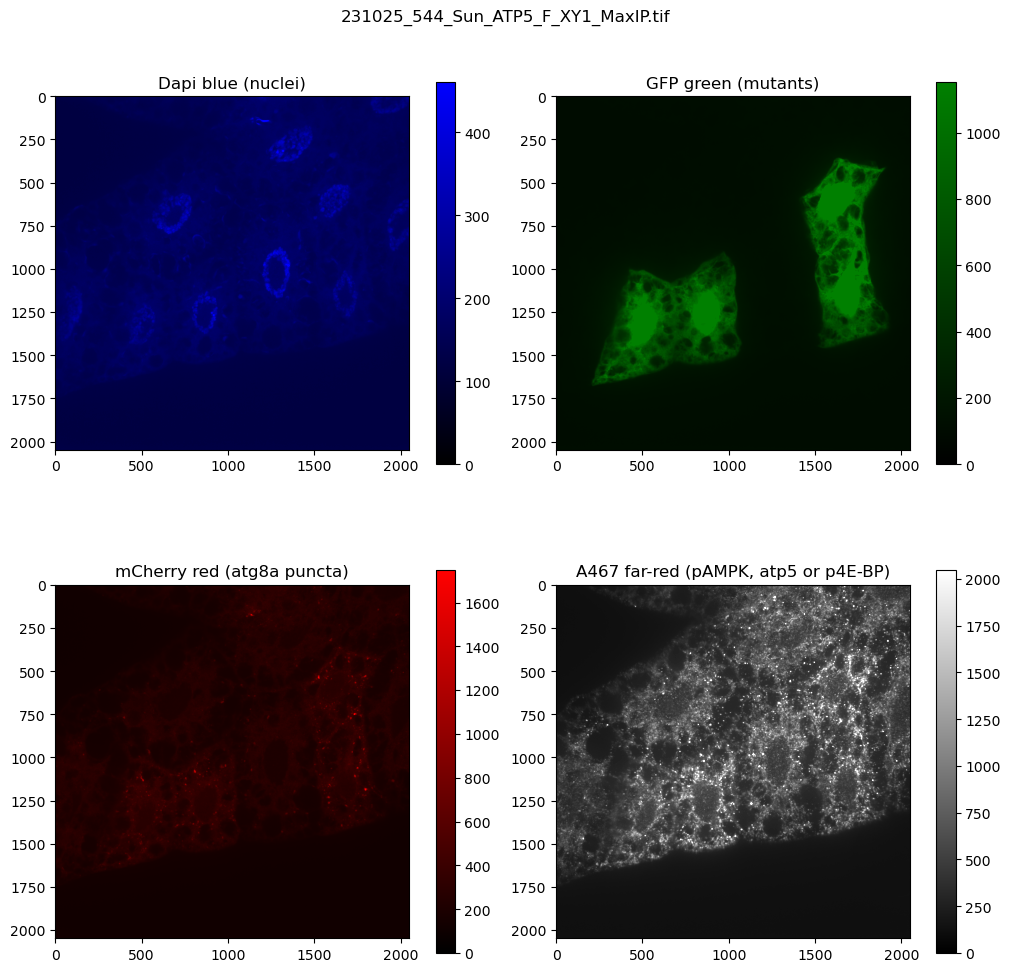

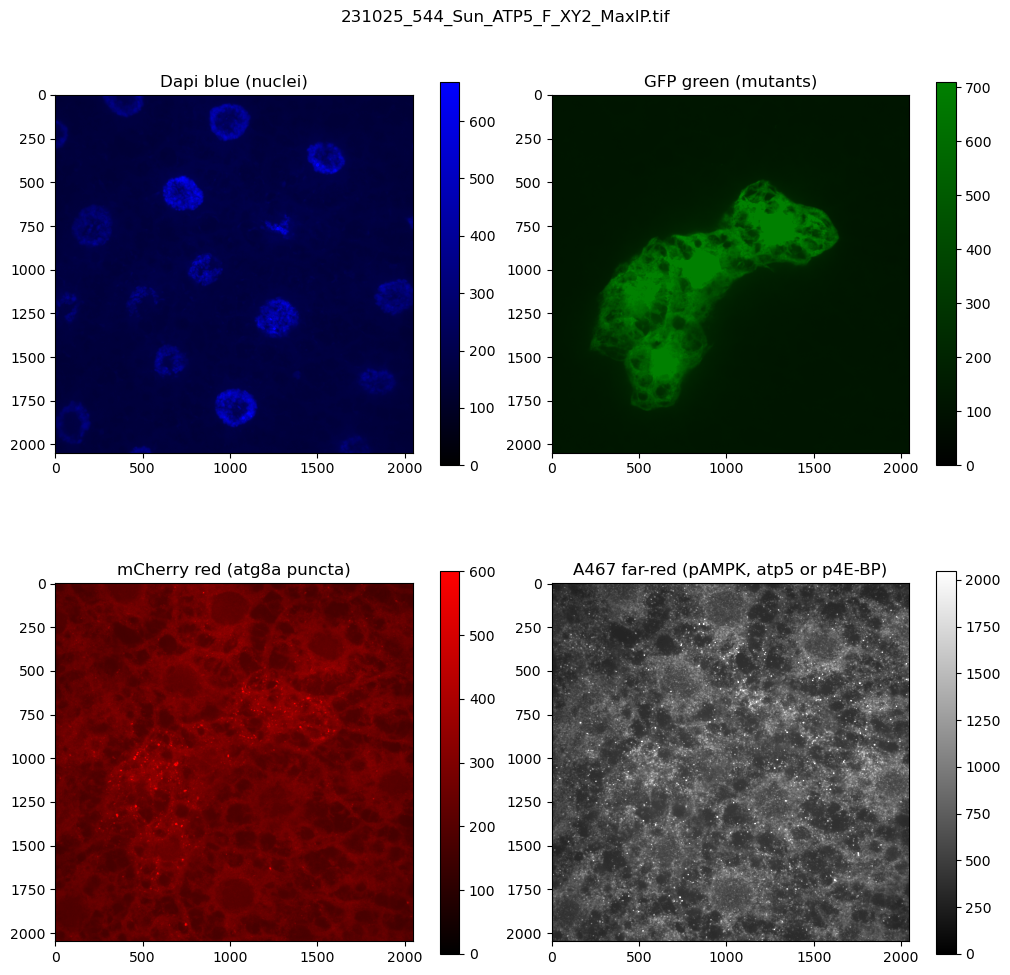

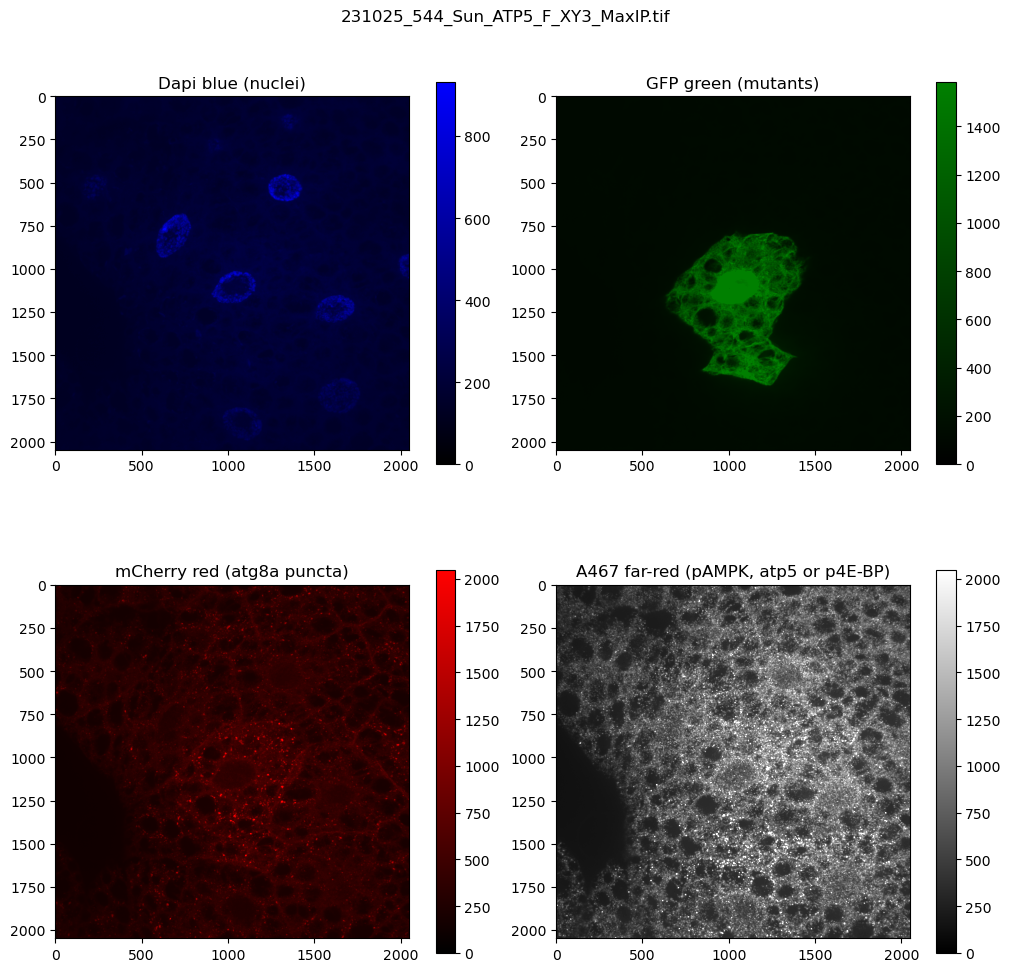

In [54]:
cwd = os.getcwd()
tiff_folder_path = cwd + "/Tiff/231025_544_ATP5_pAMPK"
count = 0
for image_name in os.listdir(tiff_folder_path):
    image_path = os.path.join(tiff_folder_path, image_name)
    image = tiff_to_array(image_path)
    plot_cropped(image_name, image,0.5, 0, 0, 2048)
    count += 1
    if count > 2:
        break

## A close up on some cells
- The max of the color scale is adjusted to better see lower pixel values
- How to find the background pixel level of a single cell? The dark areas are nuclei or fatty material and should not be included

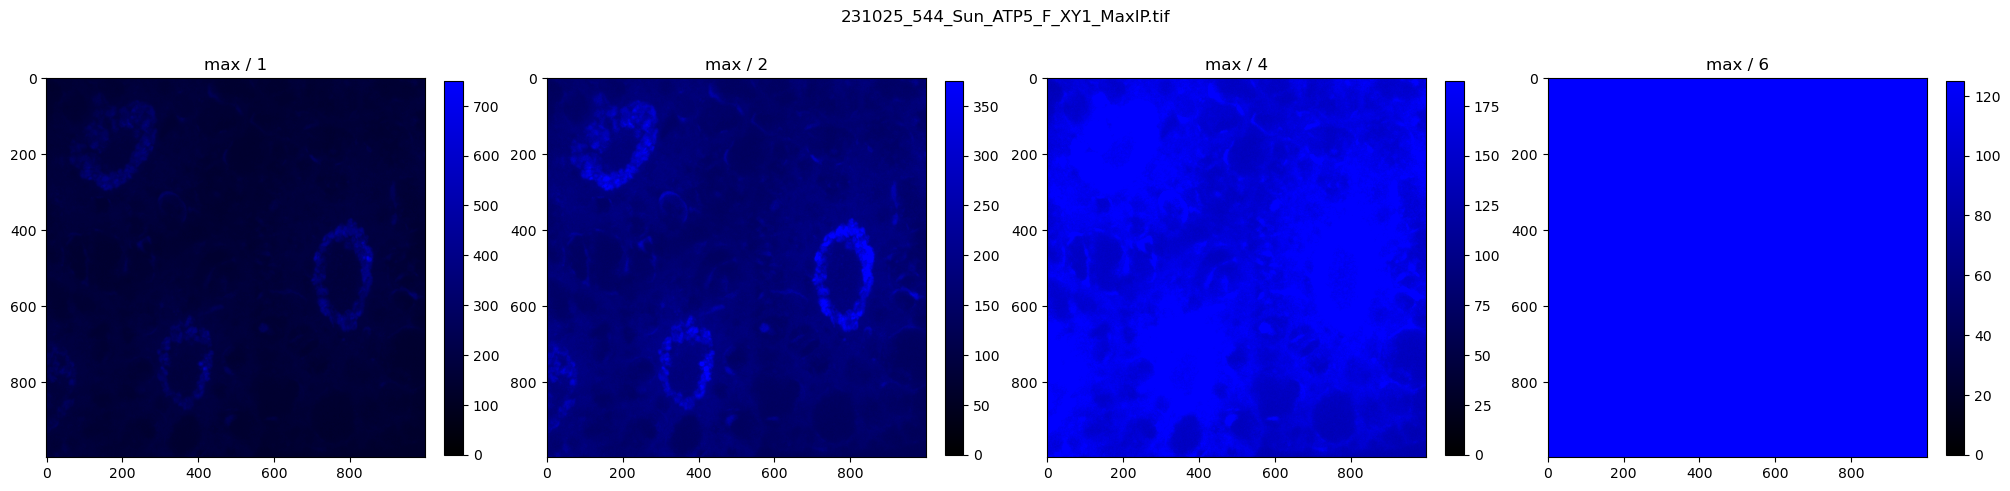

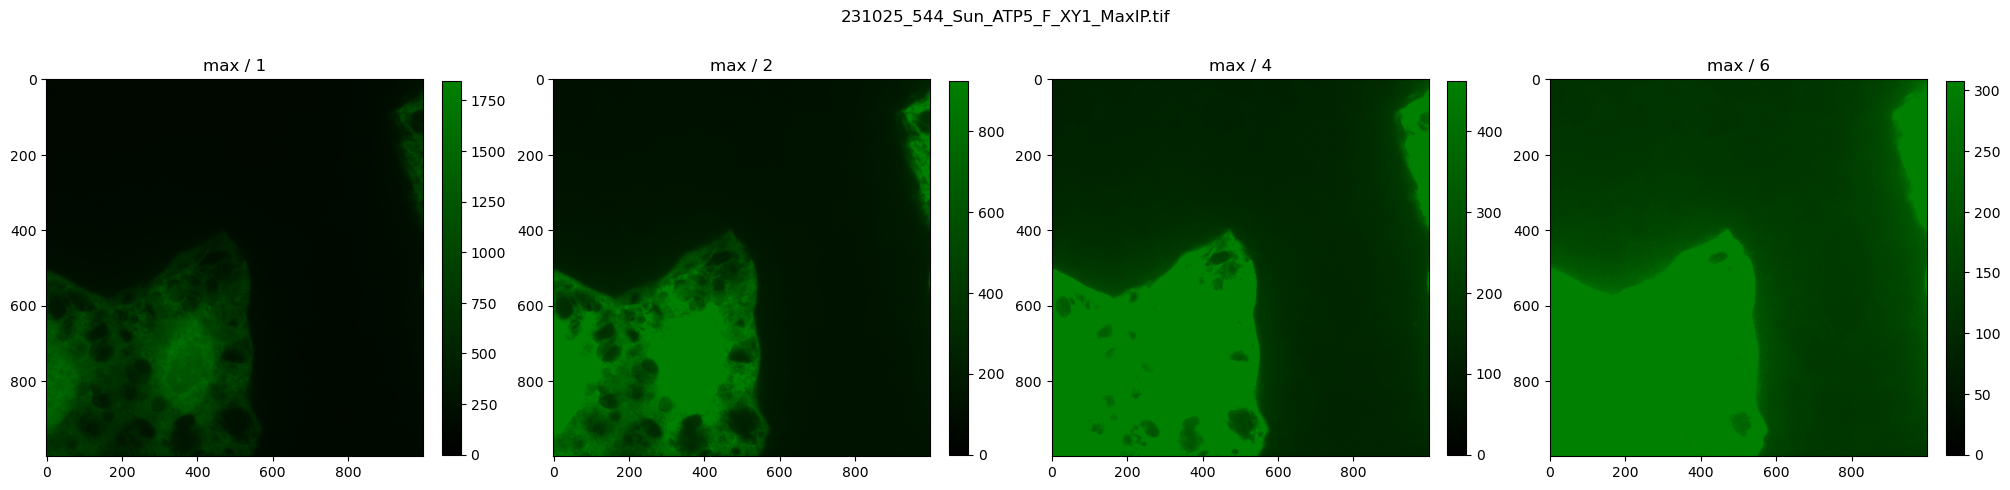

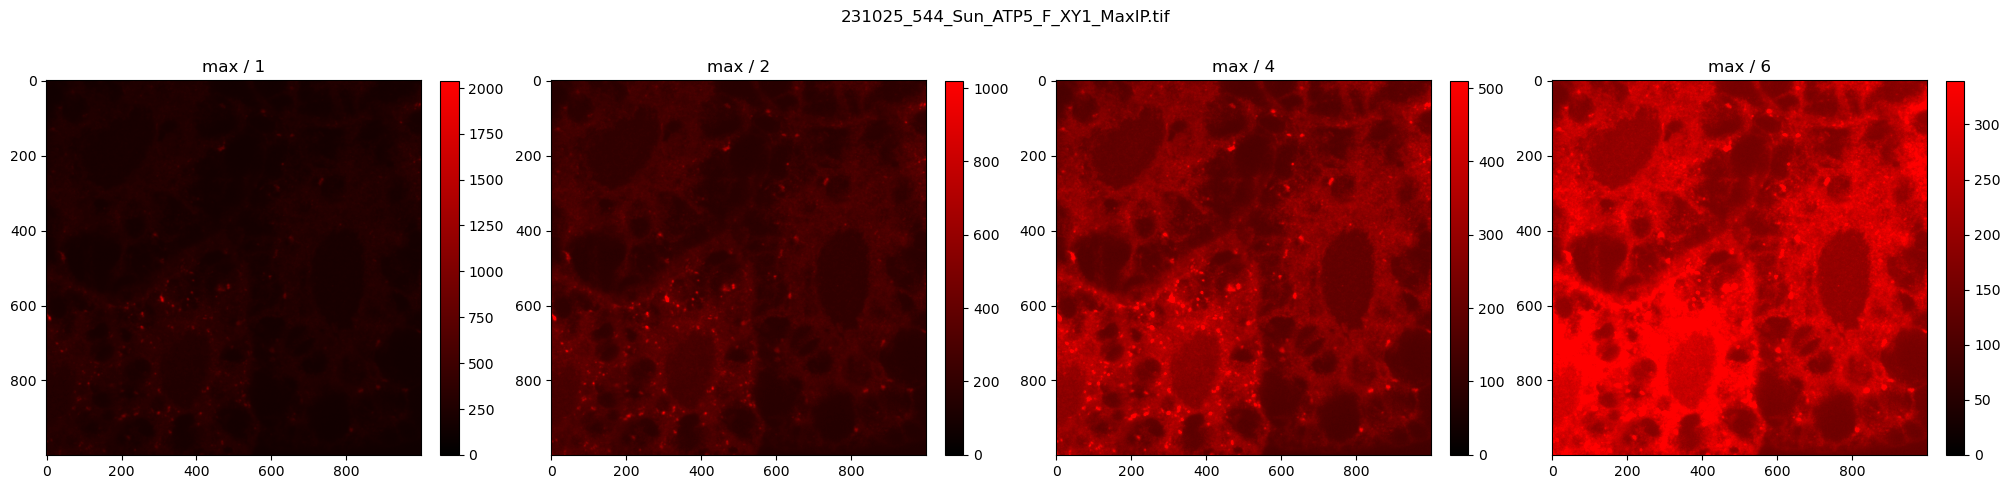

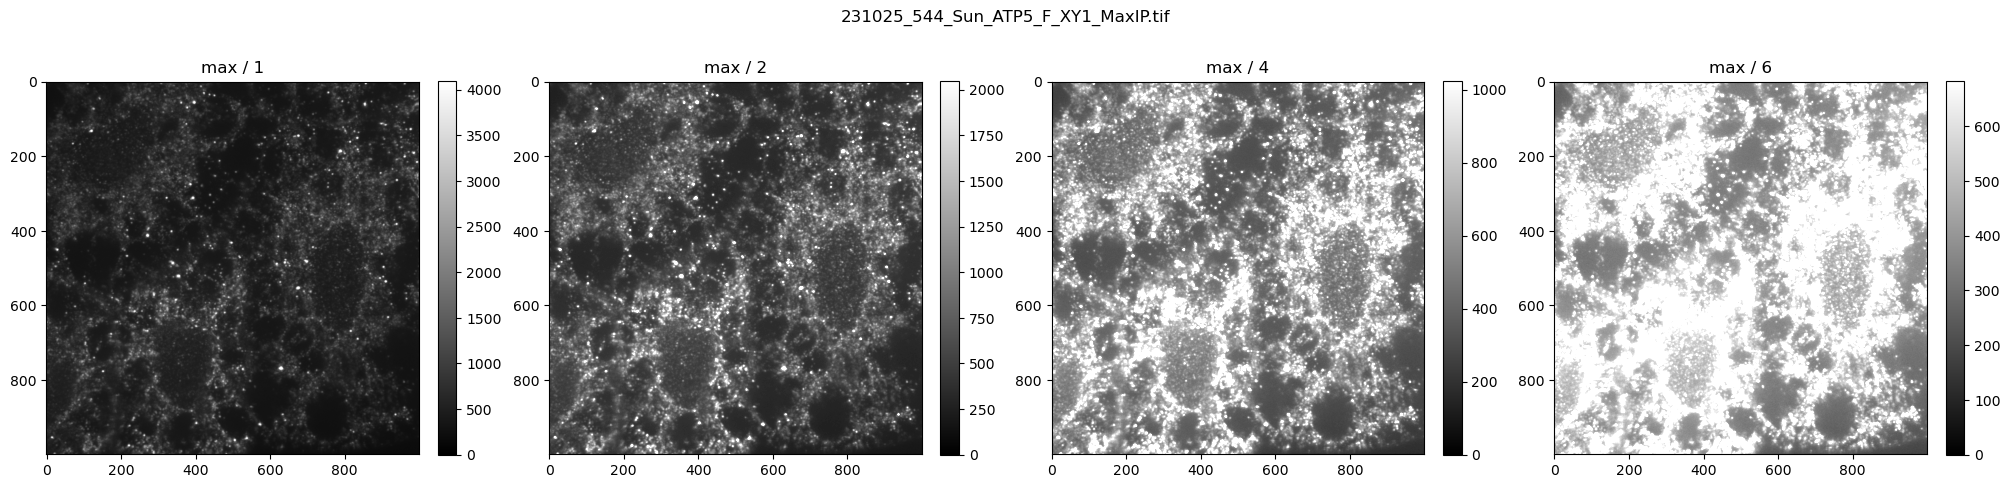

In [55]:
cwd = os.getcwd()
tiff_folder_path = cwd + "/Tiff/231025_544_ATP5_pAMPK"
count = 0
for image_name in os.listdir(tiff_folder_path):
    image_path = os.path.join(tiff_folder_path, image_name)
    image = tiff_to_array(image_path)
    plot_intensities(image_name, 0, image,1, 2, 4, 6, 500, 500, 1000)
    plot_intensities(image_name, 1, image,1, 2, 4, 6, 500, 500, 1000)
    plot_intensities(image_name, 2, image,1, 2, 4, 6, 500, 500, 1000)
    plot_intensities(image_name, 3, image,1, 2, 4, 6, 500, 500, 1000)
    count += 1
    if count > 0:
        break

## The histograms of some images
- Would be more interesting to look at the histograms of individual cells
- Can we get the background that corresponds to cytosol?

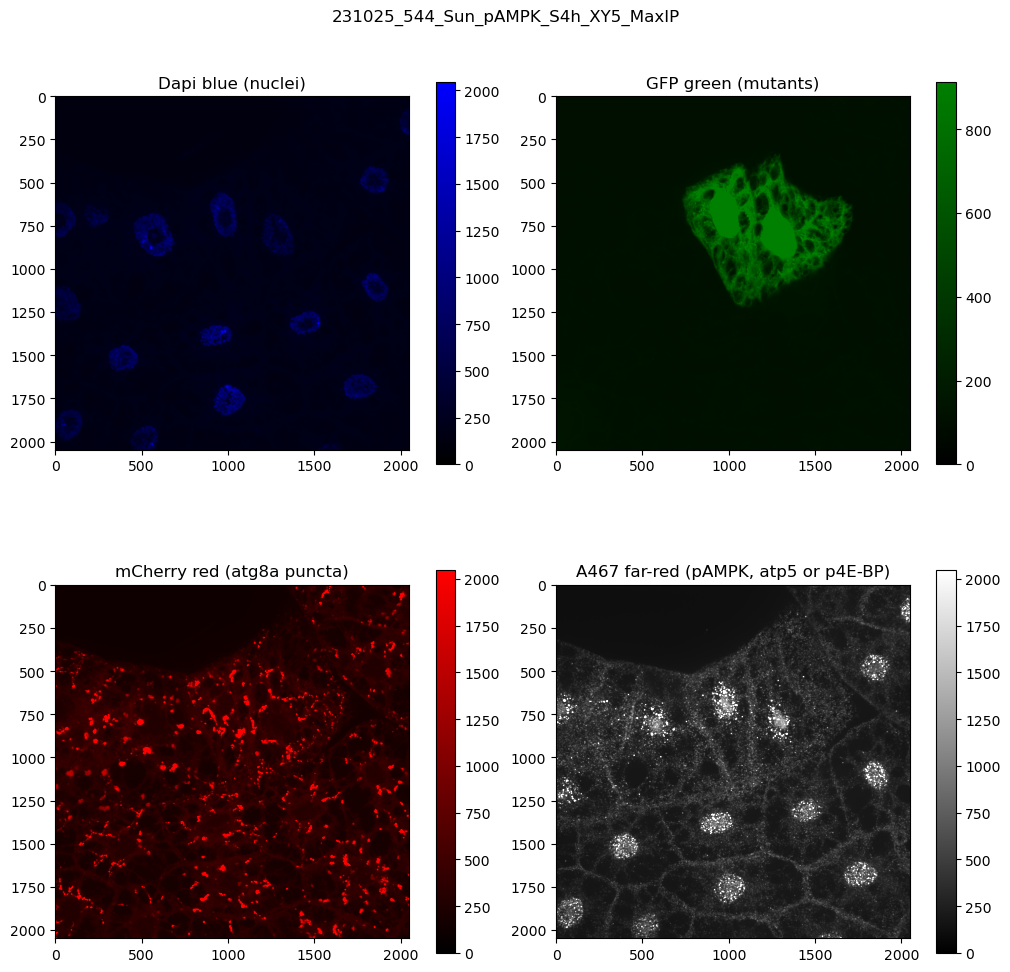

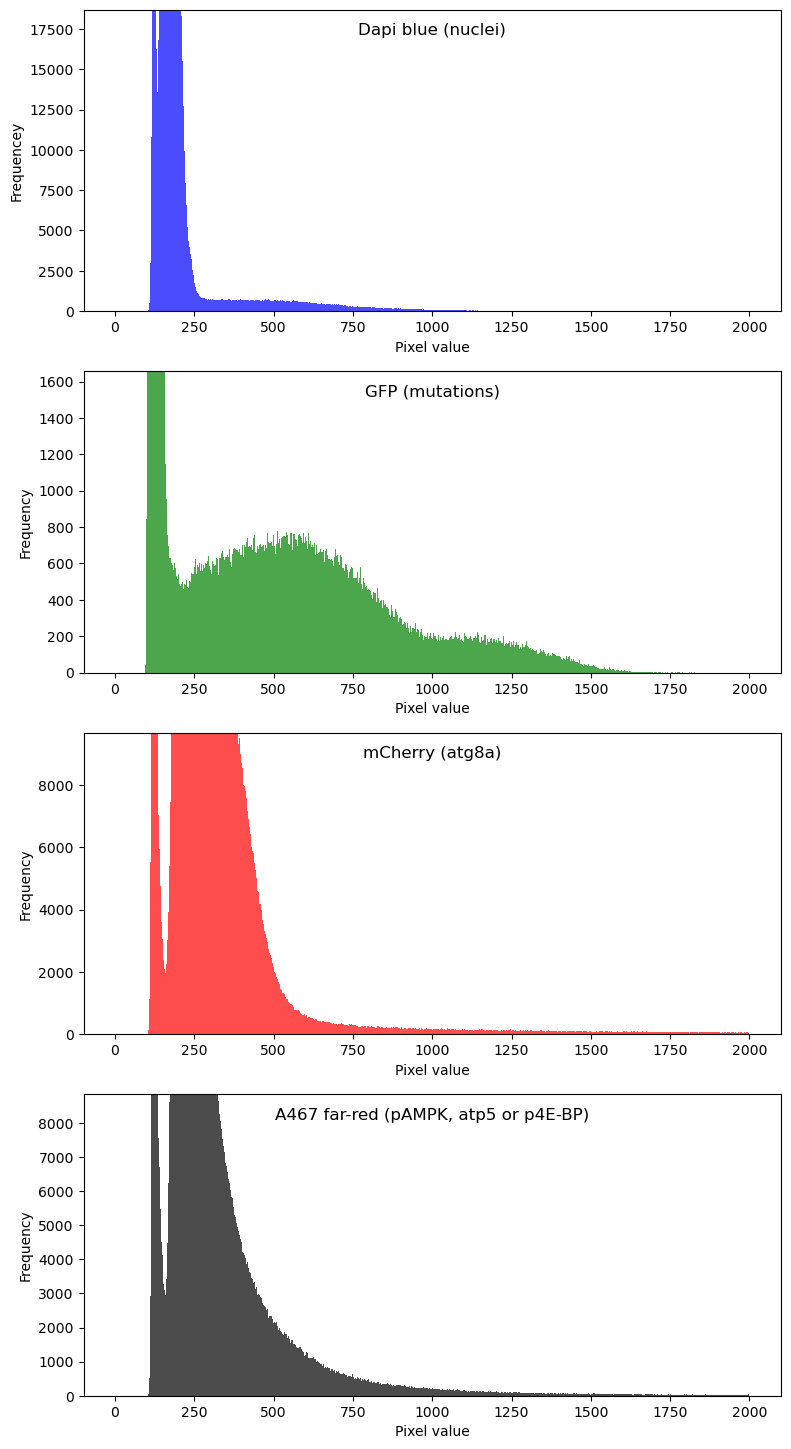

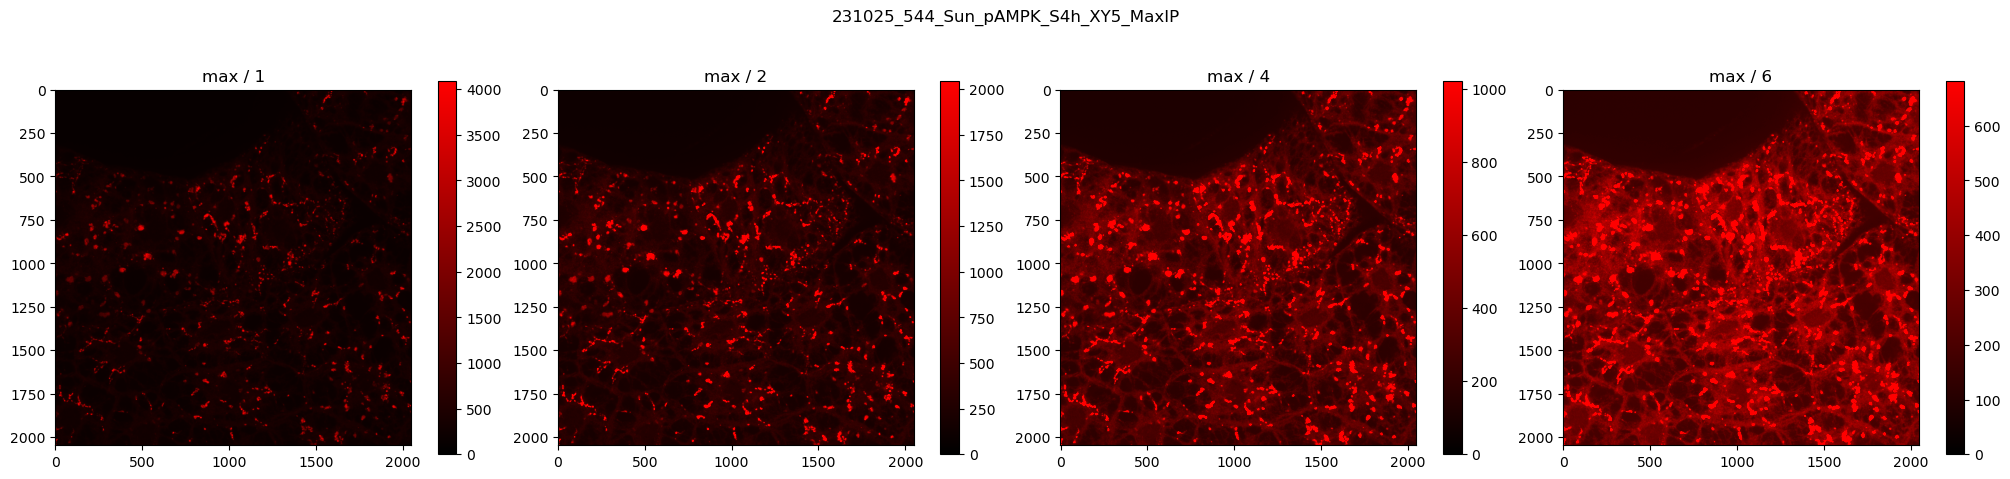

In [50]:
cwd = os.getcwd()
image_name = "231025_544_Sun_pAMPK_S4h_XY5_MaxIP"
image_path = cwd + "/Tiff/231025_544_ATP5_pAMPK/" +image_name +".tif"
image = tiff_to_array(image_path)

plot_cropped(image_name, image,0.5, 0, 0, 2048)
make_histograms(image)
plot_intensities(image_name, 2, image,1, 2, 4, 6, 0, 0, 2048)

## Chloroquine treated cells
Here are some cells that have been treated with Chloroquine, which blocks the fusion of autophagosomes with autolysosome so that the red spots we see are mostly very large autophagosomes. 
- The red spots are large and diffuse, very different from others.
- Why do the large spots overlap with the green spots if they are autophagosomes?
- What are the small and bright looking spots inside of the big ones? They look more like the autophagosome spots in other images? Are these autophagosomes that are merging with ever growing endolysosomes?
- Should we exclude these images?

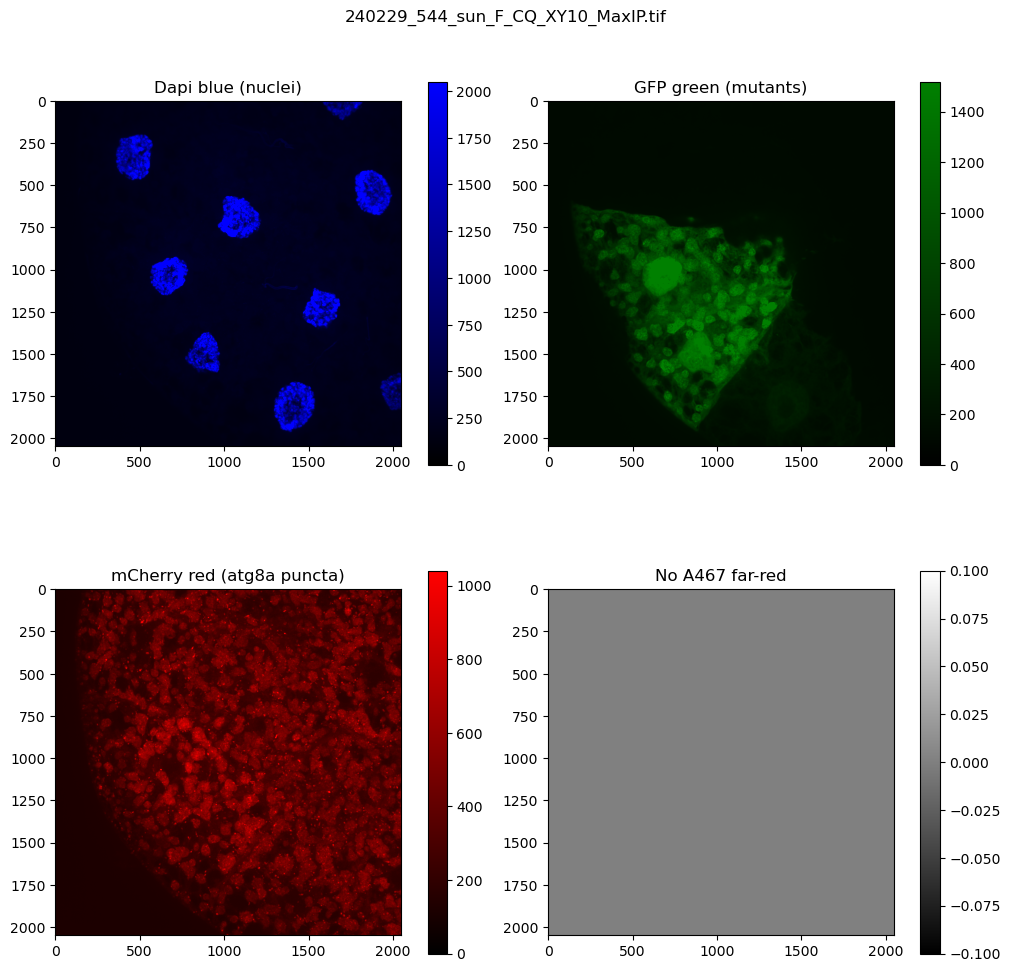

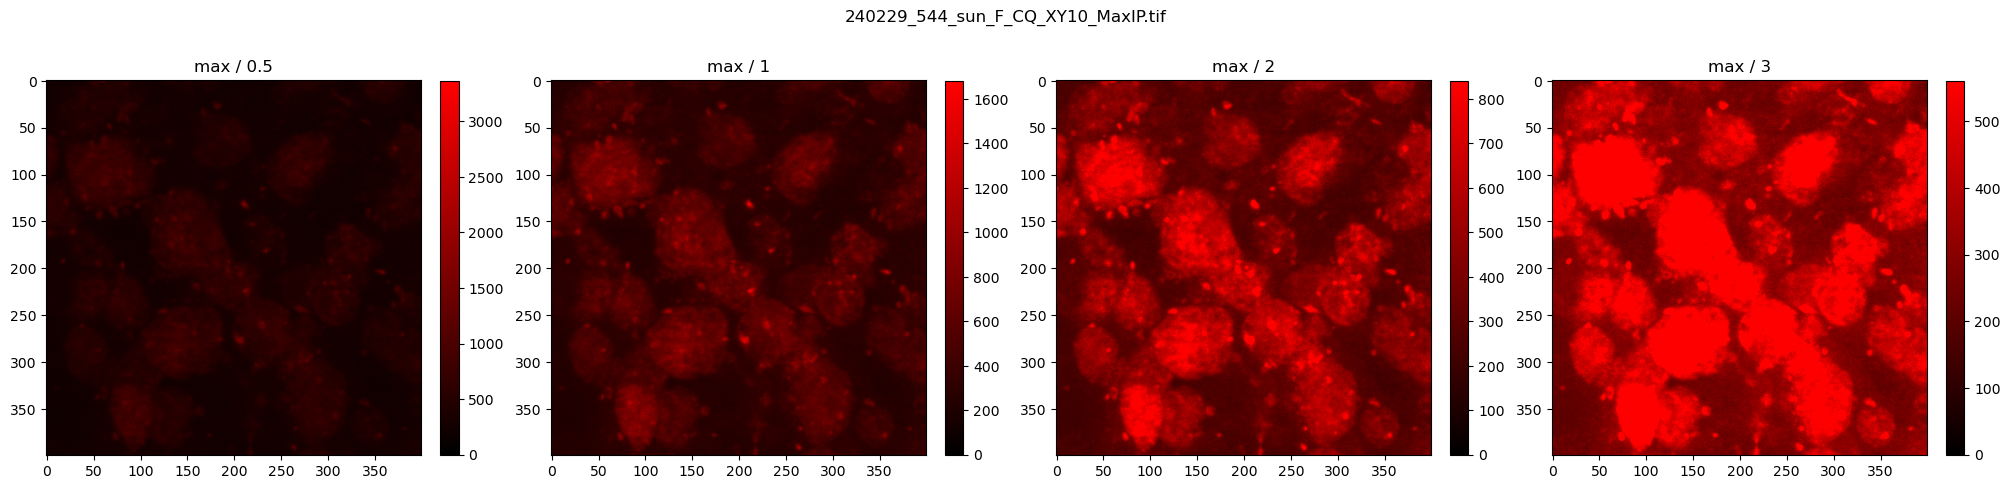

In [51]:
cwd = os.getcwd()
tiff_folder_path = cwd + "/Tiff/240229_544_sun_synF_CQ"
count = 0
for image_name in os.listdir(tiff_folder_path):
    image_path = os.path.join(tiff_folder_path, image_name)
    image = tiff_to_array(image_path)
    plot_cropped(image_name, image,0.5, 0, 0, 2048)
    plot_intensities(image_name,2, image,0.5, 1, 2, 3, 700, 700, 400)
    count += 1
    if count > 0:
        break

## Trying to visualise the overlap between the atg8a spots and the green spots

- I tried to merge the red and green images to see how they overlap (as they do in cellular but not looking for autophagic vesicles this time).
- Siri probably knows what protein the green probes are linked to, maybe it makes sense that they all group inside of autophagosomes


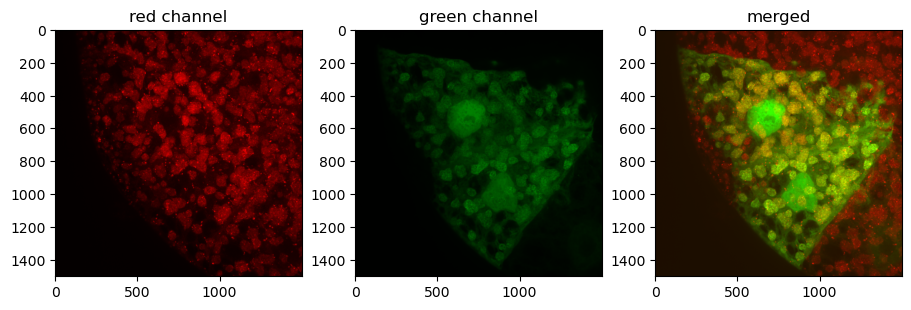

In [23]:

cwd = os.getcwd()
image_name = "240229_544_sun_F_CQ_XY10_MaxIP"
image_path = cwd + "/Tiff/240229_544_sun_synF_CQ/" +image_name +".tif"
image = tiff_to_array(image_path)
plot_new_merged_cell(image, 4, 500, 0, 1500)

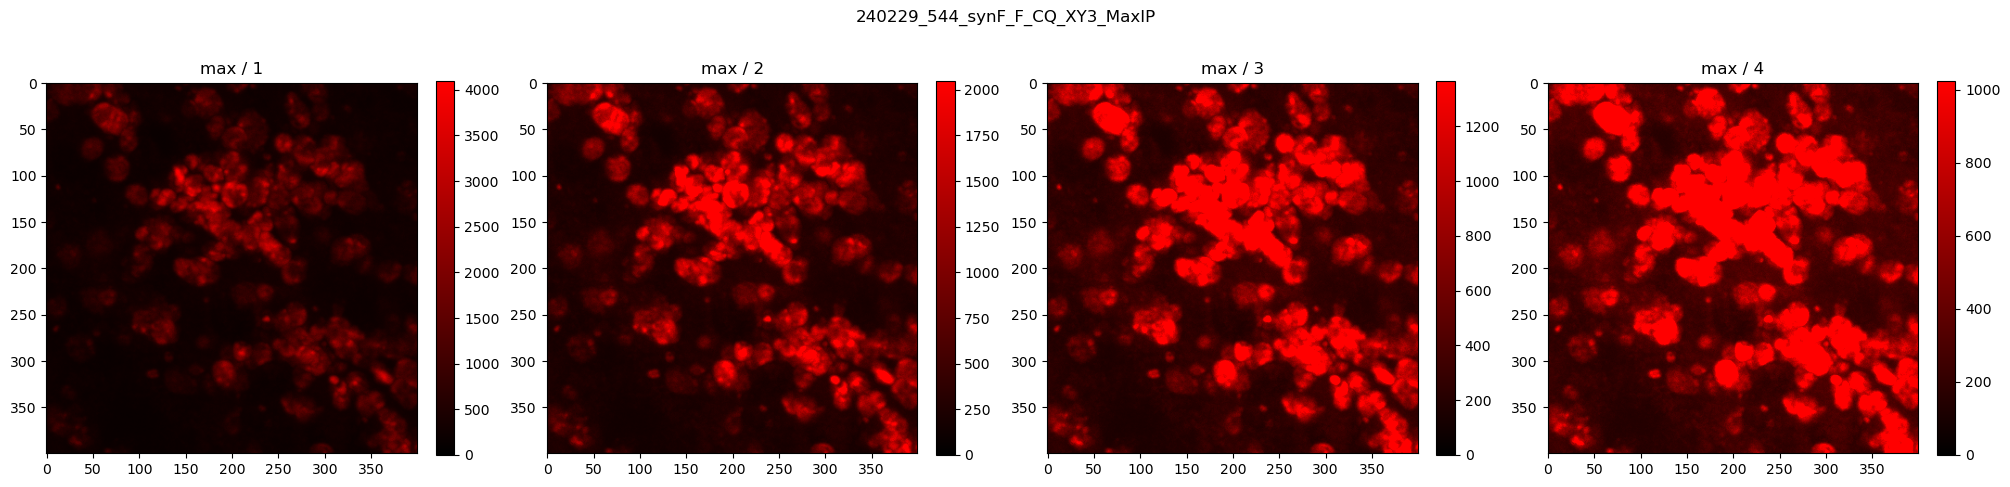

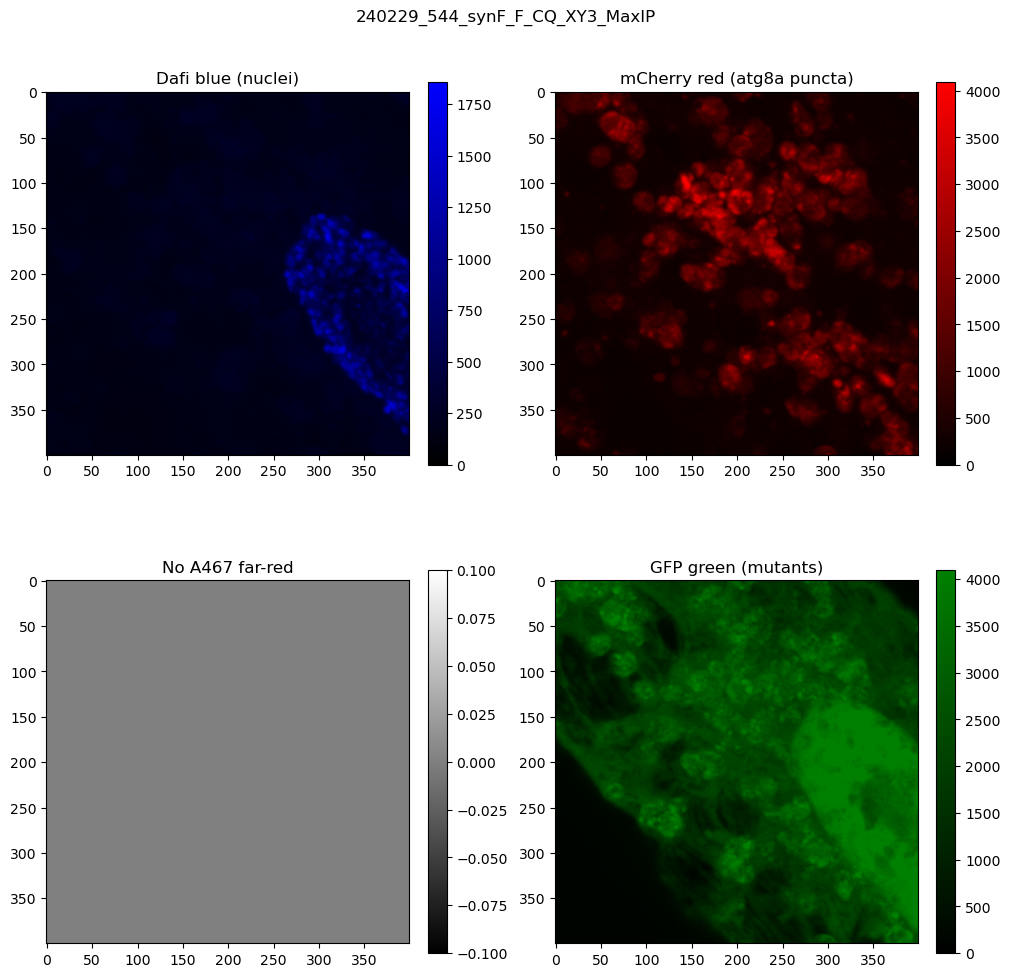

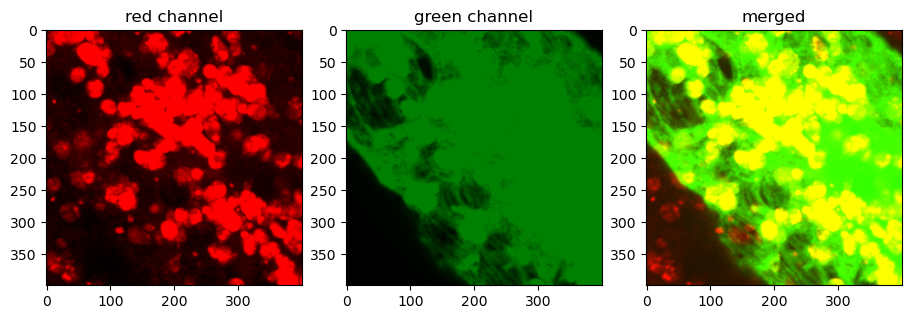

In [25]:
cwd = os.getcwd()
image_name = "240229_544_synF_F_CQ_XY3_MaxIP"
image_path = cwd + "/Tiff/240229_544_sun_synF_CQ/" +image_name +".tif"
image = tiff_to_array(image_path)
plot_intensities(image_name, image,1, 2, 3, 4, 700, 700, 400)
plot_cropped(image_name, image,1, 700, 700, 400)
plot_new_merged_cell(image, 4, 700, 700, 400)



## Some green cells appearing in the dark..

-  These cells are either new mutants or autofluorescence, but most probably the latter if they are brighter than the background.
-  There is autofluoresence enough to see cell structure at around pixel value of 200

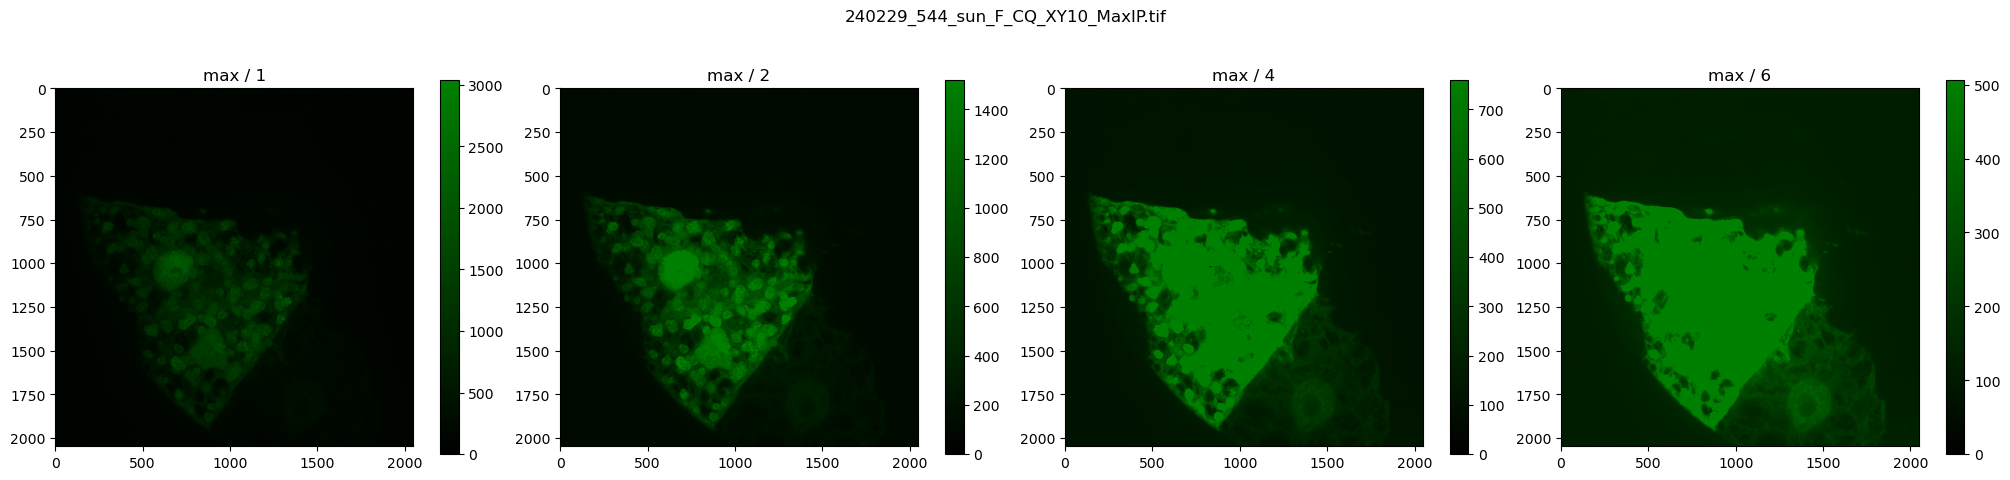

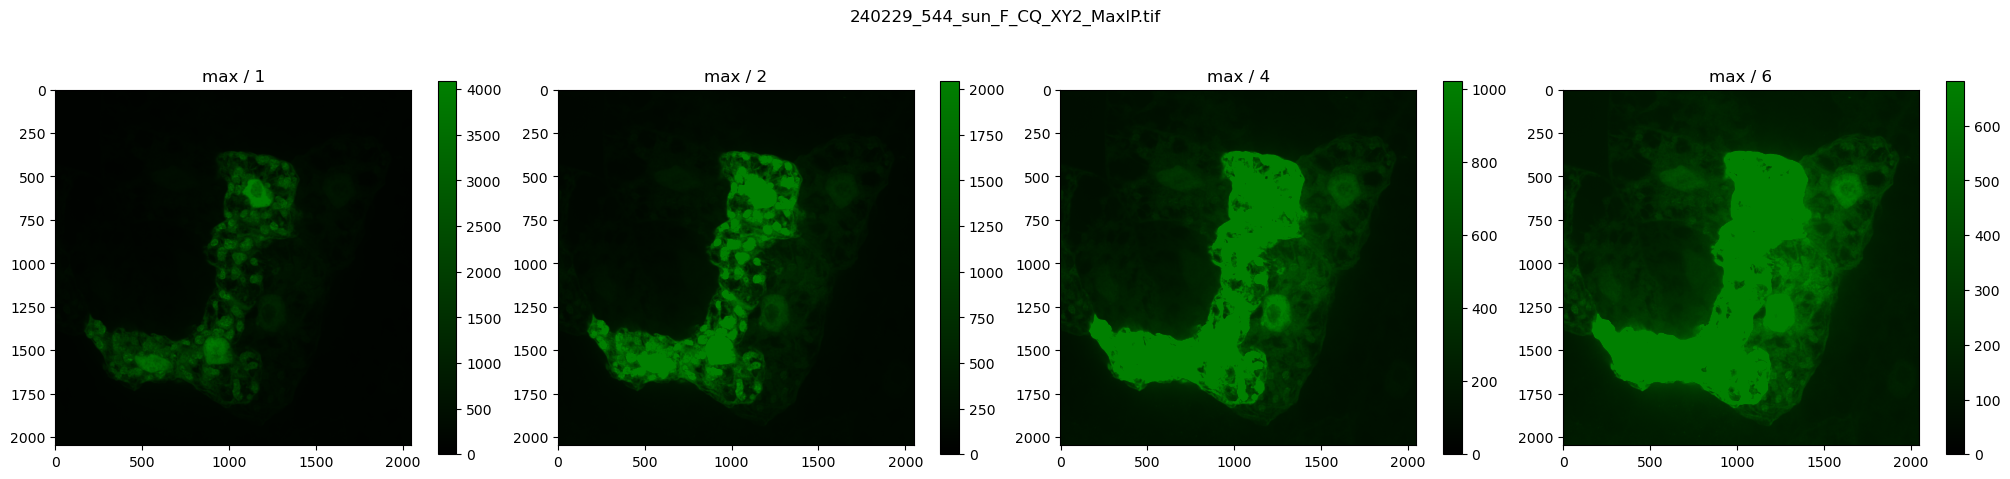

In [33]:
cwd = os.getcwd()
tiff_folder_path = cwd + "/Tiff/240229_544_sun_synF_CQ"
count = 0
for image_name in os.listdir(tiff_folder_path):
    image_path = os.path.join(tiff_folder_path, image_name)
    image = tiff_to_array(image_path)
    plot_intensities(image_name, 1, image,1, 2, 4, 6, 0, 0, 2048)
    count += 1
    if count > 1:
        break

## Some thoughts on what we could do:
- Make GT for cell segmentation if it can be done efficiently using the cells in the green channel
- Segment all cells in the images using the other three channels (there is also some low autofluoroscence in the green channel that could have been used, if it would not have been for the fact that some cells are in the GT we could use this channel as well)
- Prepare already segmented red spots as GT on cell level. We may need to take into account that not all spots have been found + that some spots may have appeared due to tuning of brightness)
- Train segmentation model to segment red spots on the new experiments with in vivo data
- Test the segmentation model on the Cellular data set, since spots should be similar in the red channel.
- Investigate how the spot segmentation differs when we have access to both red and green channel in the Cellular data set. This should change segmentation since some spots are only visible as a lack of brightness in the green channel

### Making the single channel jpgs

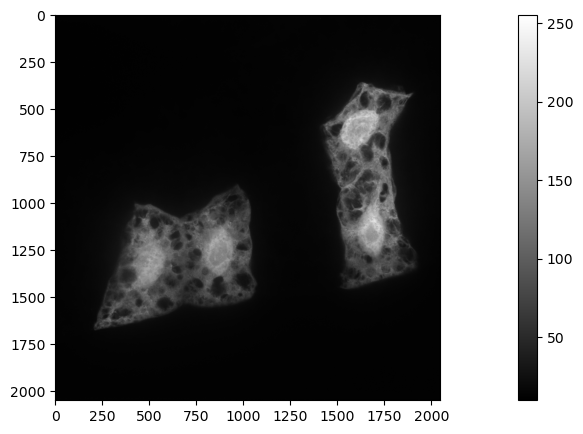

In [160]:
from PIL import Image
cwd = os.getcwd()
tiff_folder_path = cwd + "/Tiff/231025_544_ATP5_pAMPK"
count = 0
channel = 1
for image_name in os.listdir(tiff_folder_path):
    image_path = os.path.join(tiff_folder_path, image_name)
    image_16 = tiff_to_array(image_path)
    max_value = image_16[channel,:,:].max() # normalize with recpect to max value
    image_8 = (image_16/max_value*255).astype('uint8')
    image_name = image_name[:-4]
    im = Image.fromarray(image_8[channel,:,:])
    im.save(f"{image_name}_{channel}.jpg", quality=95)

    count += 1
    if count > 0:
        break

# Plot in greyscale
grey_cmap = LinearSegmentedColormap.from_list("", ["black","white"])
fig = plt.figure()
im1 = plt.imshow(im, cmap = grey_cmap)
cbar = fig.colorbar(im1)